In [54]:
from forced_convection_dft.forward_models import ForwardModelDft, ForwardModelThermocouple
from forced_convection_dft.find_incident_heat_flux import HeatFluxFinder
from dft_inverse_code import dft_models, heat_transfer_coefficients
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import plot_settings
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'axes.labelsize':24})
plt.rcParams.update({'axes.titlesize':24})
plt.rcParams.update({'legend.fontsize':24})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation info

In [2]:
dt = .1
constant = 273.15
time_vector = np.arange(0, 11 * 60 + dt, dt)


# Properties

In [3]:
diameter_tc = 1.4e-3
density_tc = 8665
heat_capacity_tc = 485.6 
emissivity_tc = 0.8
alpha_tc = 0.8
dft_thickness =  0.0016
insulation_thickness = .019
plate_side_length = .0762

In [4]:
velocities = [2, 4, 6]
flux = 10
errors_framework = np.zeros_like(time_vector)
errors_nat_conv = np.zeros_like(time_vector)

q_inc_true = np.zeros((len(velocities), len(time_vector)))
q_inc_recovered_framework = np.zeros((len(velocities), len(time_vector)))
q_inc_recovered_nat_conv = np.zeros((len(velocities), len(time_vector)))

h_true = np.zeros((len(velocities), len(time_vector)))
h_recovered_framework = np.zeros((len(velocities), len(time_vector)))
h_recovered_nat_conv = np.zeros((len(velocities), len(time_vector)))

q_conv_true = np.zeros((len(velocities), len(time_vector)))
q_conv_recovered_framework = np.zeros((len(velocities), len(time_vector)))
q_conv_recovered_nat_conv = np.zeros((len(velocities), len(time_vector)))

In [5]:
def run_forward_models(time, insulation_thick, steel_thickness, q_incident, v, epsilon_tc, alph_tc, diam_tc, c_tc,
                       rho_tc, side_length):
    forward_dft = ForwardModelDft(n_nodes=10, time=time, insul_thickness=insulation_thick, plate_thickness=steel_thickness, q_inc=q_incident,
                                  characteristic_velocity=v, temp_init=21 + constant, temp_amb=21 + constant, temp_surr=21 + constant, dft_plate_length=side_length)
    temp_front, temp_back, temp_insulation, h_f, h_back = forward_dft.run()
    forward_tc = ForwardModelThermocouple(time, q_incident, v, 21 + constant,
                                          21 + constant, 21 + constant, epsilon_tc, alph_tc, diam_tc, c_tc,
                                          rho_tc)
    temperature_tc = forward_tc.run()
    return temp_front, temp_back, temp_insulation, h_f, h_back, temperature_tc

def recover_using_framework(q_incident_true, temp_front, temp_back, temperature_tc, time, diam_tc, alph_tc, c_tc, rho_tc):
    hf_finder = HeatFluxFinder(temp_front, temp_back, temperature_tc, 21 + constant,
                               21 + constant, 21 + constant, time, diam_tc,
                               alph_tc, alph_tc, c_tc, rho_tc,
                               constant_velocity=True,
                               plate_side_length=plate_side_length)
    q_inc_plate_recovered = hf_finder.find_q_inc()
    error = np.abs((q_inc_plate_recovered - q_incident_true) / q_incident_true)
    error = error[np.isfinite(error)].mean() * 100
    return q_inc_plate_recovered, hf_finder.h_front_dft, error

def recover_using_nat_assumption(q_incident_true, temp_front, temp_back, time):
    h_nat_conv = heat_transfer_coefficients.natural_convection(
        (temp_front + 21 + constant).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=21 + constant).custom(0.65, 0.25).flatten()
    q_inc_recovered = dft_models.one_dim_conduction(T_f=temp_front, T_b=temp_back, time=time, h_f=h_recovered_nat_conv[i], h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=21 + constant, T_sur=21 + constant).q_inc

    error = np.abs((q_inc_recovered - q_incident_true) / q_incident_true)
    error = error[np.isfinite(error)].mean() * 100
    return q_inc_recovered, h_nat_conv, error
    
    

In [6]:
for i, vel in enumerate(velocities):
    velocity = np.ones(len(time_vector)) * vel
    q_inc = np.ones_like(time_vector) * flux * 1e3
    q_inc[time_vector < 3 * 60] = 0
    q_inc[time_vector > 8 * 60] = 0
    temp_f, temp_b, temp_ins, h_true[i], h_b, temp_tc = run_forward_models(time_vector, insulation_thickness, dft_thickness, q_inc, velocity, emissivity_tc, alpha_tc, diameter_tc, heat_capacity_tc, density_tc, plate_side_length)
    q_conv_true[i] = - h_true[i] * (temp_f - 21 - constant) / 1e3
    q_inc_true[i] = q_inc / 1e3
    q_inc_recovered_framework[i], h_recovered_framework[i], errors_framework[i] = recover_using_framework(q_inc_true[i], temp_f, temp_b, temp_tc, time_vector, diameter_tc,  alpha_tc, heat_capacity_tc, density_tc)
    q_conv_recovered_framework[i] = - h_recovered_framework[i] * (temp_f - 21 - constant) / 1e3
    h_recovered_nat_conv[i] = heat_transfer_coefficients.natural_convection(
            (temp_f + 21 + constant).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=21 + constant).custom(0.65, 0.25).flatten()
    q_inc_recovered_nat_conv[i] = dft_models.one_dim_conduction(T_f=temp_f, T_b=temp_b, time=time_vector, h_f=h_recovered_nat_conv[i], h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=21 + constant, T_sur=21 + constant).q_inc

    q_inc_recovered_nat_conv[i], h_recovered_nat_conv[i], errors_nat_conv[i] = recover_using_nat_assumption(q_inc_true[i], temp_f, temp_b, time_vector)
    q_conv_recovered_nat_conv[i] = - h_recovered_nat_conv[i] * (temp_f - 21 - constant) / 1e3
    

100%|██████████| 6600/6600 [00:00<00:00, 15160.77it/s]


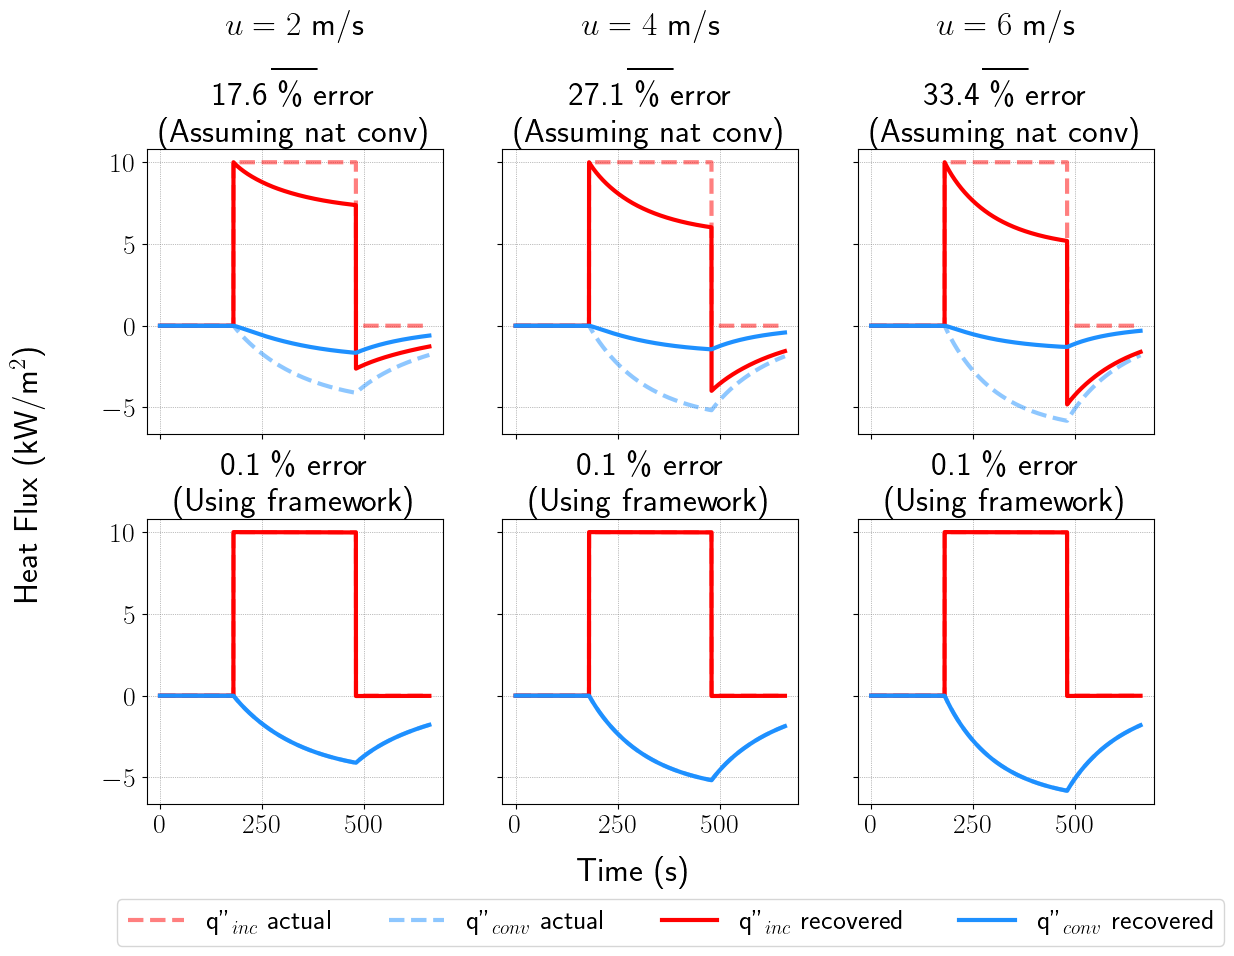

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(13, 8.5))
for col, (ax, vel) in enumerate(zip(axes.T, velocities)):
    for row, sub_ax in enumerate(ax): 
        sub_ax.plot(time_vector, q_inc_true[col], color='red', alpha=.5, linestyle='--', label="q''$_{inc}$ actual")
        sub_ax.plot(time_vector, q_conv_true[col], color='dodgerblue', alpha=.5, linestyle='--', label="q''$_{conv}$ actual")
    ax[0].plot(time_vector, q_inc_recovered_nat_conv[col], color='red', label="q''$_{inc}$ recovered")
    ax[0].plot(time_vector, q_conv_recovered_nat_conv[col], color='dodgerblue', label="q''$_{conv}$ recovered")
    ax[1].plot(time_vector, q_inc_recovered_framework[col], color='red', label="q''$_{inc}$ recovered")
    ax[1].plot(time_vector, q_conv_recovered_framework[col], color='dodgerblue', label="q''$_{conv}$ recovered")
    ax[0].set_title(f"$u = {vel}$ m/s\n-----\n{np.round(errors_nat_conv[col], 1)} \% error\n (Assuming nat conv)")
    ax[1].set_title(f"{np.round(errors_framework[col], 1)} \% error\n (Using framework)")
   
axes[1, 0].legend(ncol=4, loc=(-0.1, -.5), fontsize=20)
fig.supylabel('Heat Flux (kW/m$^2$)', fontsize=24)
fig.supxlabel('Time (s)', fontsize=24)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()
plt.savefig('../../dissertation_franqueville/chapters/dft_chapter/figures/constant_ex.png', dpi=300, bbox_inches='tight');


0.013282423366238525
0.024412579033006712
0.03014564360168598


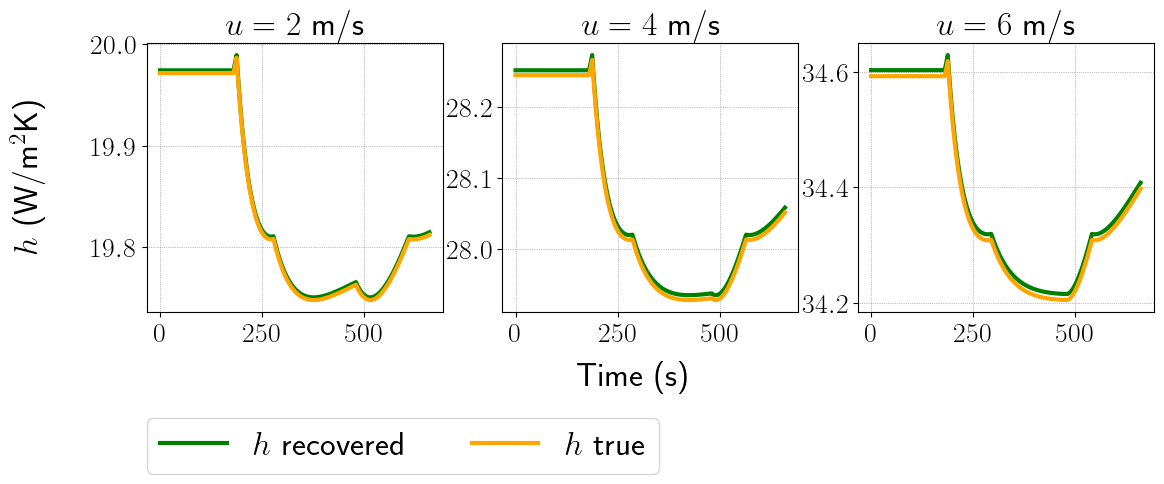

In [56]:

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(13, 3.5))
for col, (ax, vel) in enumerate(zip(axes.T, velocities)):
    ax.plot(time_vector, h_recovered_framework[col], color='green', label="$h$ recovered")
    ax.plot(time_vector, h_true[col], color='orange', label="$h$ true")
    print(np.abs((h_recovered_framework[col]- h_true[col])/ h_true[col]).mean() * 100)
    ax.set_title(f"$u = {vel}$ m/s")
axes[0].legend(ncol=4, loc=(0, -.6))
fig.supylabel('$h$ (W/m$^2$K)', fontsize=24)
fig.text(0.5, -.1, 'Time (s)', ha='center', fontsize=24);
plt.savefig('../../dissertation_franqueville/chapters/dft_chapter/figures/constant_h.png', dpi=300, bbox_inches='tight');
